# Connectome Overview, Basic Statistics, and Visualizations #

This notebook provides an overview of the 14 connectomes available in the connectocross repository, along with visualizations of each one and some basic statistics

In [1]:
import os
import sys
sys.path.append("../")
import graspologic as gr
import networkx as nx
from graph import GraphIO
import pandas as pd

## Ciona Intestinalis Larval Connectome ##

This is a very detailed connectome of the ascidian tadpole larva create via careful EM imaging. Multiple hermaphroditic individuals were imaged. The original study was looking for topological asymmetries between hemispheres in Ciona's central nervous system (CNS). The connectome includes mostly CNS Neurons.

{cite}`ryan_cns_2016`

In [2]:
path = '../json_connectomes/ciona.json'
connectome, _, _, _ = GraphIO.load(path)

Now we generate a 2-dimmensional node layout using Graspologic's `layout_tnse`. This function creates a layout that shows
the community structure of the data.

In [3]:
undirected_connectome = nx.convert_node_labels_to_integers(connectome.to_undirected())
undirected_connectome, layout = gr.layouts.layout_tsne(undirected_connectome,
                                                       perplexity=20,
                                                       n_iter=1000000)

Next we must assign a color to the nodes in the graph. Here we base the colors on node "Side" attributes. Left is Blue,
Right is Red, and Medial is Purple. Nodes without a side attribute are grey.

In [4]:

color_map = {}
side_map = {'L': '#FF0000', 'DL': '#B22222', 'VL': '#F08080',
            'R': '#0000FF', 'DR': '#00008B', 'VR': '#87CEEB',
            'DM': '#800080', 'D': '#800080', 'VM': '#BA55D3',
            None: '#A9A9A9'}

for node in undirected_connectome.nodes(data=True):
    try:
        side = node[1]['Side'].strip()
    except KeyError:
        side = None
    color_map[node[0]] = side_map[side]

Now we will show the generated and colored layout

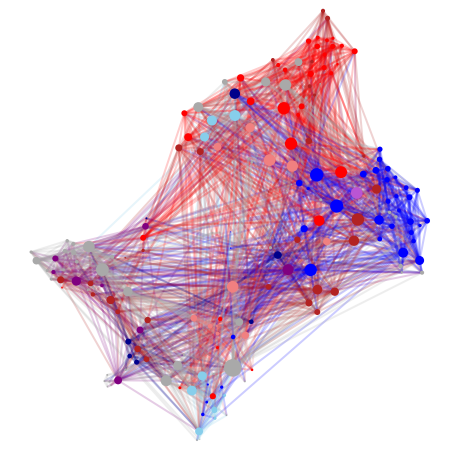

In [5]:
gr.layouts.show_graph(undirected_connectome, layout, color_map,
                      vertex_shape='.', vertex_alpha=1.,
                      edge_alpha=.2, edge_line_width=2.,
                      dpi=70, figure_height=8, figure_width=8)

Now lets display some basic graph statistics:

In [6]:
data = {'Number of Nodes': [],
        'Number of Edges': [],
        'Density': [],
        'Max Out Degree': [],
        'Max In Degree': []}
num_nodes = len(connectome.nodes)
data['Number of Nodes'].append(num_nodes)
num_edges = len(connectome.edges)
data['Number of Edges'].append(num_edges)
data['Density'].append(num_edges / (num_nodes * (num_nodes - 1)))
data['Max Out Degree'].append(max(connectome.out_degree, key=lambda x: x[1])[1])
data['Max In Degree'].append(max(connectome.in_degree, key=lambda x: x[1])[1])
df = pd.DataFrame.from_dict(data)
df.index = ['Ciona Intestinalis',]
df.head()

,Number of Nodes,Number of Edges,Density,Max Out Degree,Max In Degree
Ciona Intestinalis,222,3122,0.063634,46,78


## C. Elegans: Connectomes Over Development ##

This dataset seeks to elucidate how connectomes change over development. Eight different EM connectomes were constructed
from C. Elegans Hermaphrodites at evenly spaced time intervals from birth until adulthood.

{cite}`witvliet_connectomes_2020`

When loading the connectomes below, we must flatten the multigraphs. This is because chemical and electrical synapses are included, so some nodes
may have two pairs of edges between them. Here we rectify this by summing weights of multiedges (the default mode for `GraphIO.flatten_multigraph`)

In [7]:
# load some elegans witvilet data
ages = []
base = '../json_connectomes/witvilet/'
graph_files = sorted(os.listdir(base))
connectomes = []
for f in graph_files:
    g = GraphIO.load(os.path.join(base, f))[0]
    ages.append(g.graph['age'])
    connectomes.append(GraphIO.flatten_multigraph(g))

We follow the same steps as for Ciona (above) to generate visualizations, only here we loop over all 8 connectomes.

In [8]:
layouts = [None]*len(connectomes)
undirected_cleaned = [None]*len(connectomes)
for i, connectome in enumerate(connectomes):
    temp_g = nx.convert_node_labels_to_integers(connectome.to_undirected())
    undirected_cleaned[i], layouts[i] = gr.layouts.layout_tsne(temp_g,
                                                               perplexity=20,
                                                               n_iter=10000000)


In [9]:
color_maps = [{} for i in range(len(connectome))]
hemi_map = {'left': '#FF0000',
            'right': '#0000FF',
            None: '#A9A9A9'}
for i, connectome in enumerate(undirected_cleaned):
    for node in connectome.nodes(data=True):
        try:
            side = node[1]['hemisphere'].strip()
        except (AttributeError, KeyError):
            side = None
        color_maps[i][node[0]] = hemi_map[side]

#1 C. Elegans, Age 0 hours


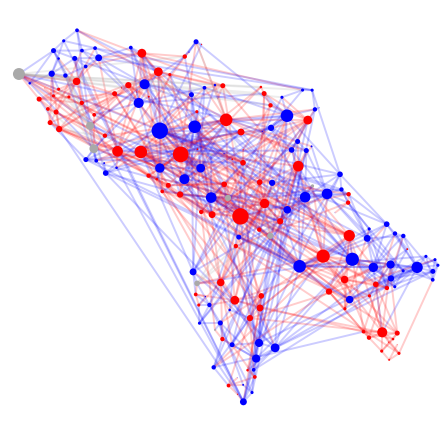

#2 C. Elegans, Age 5 hours


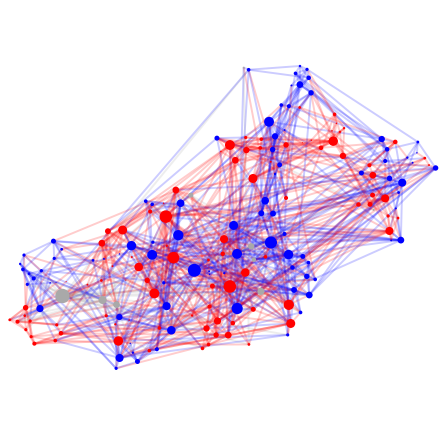

#3 C. Elegans, Age 8 hours


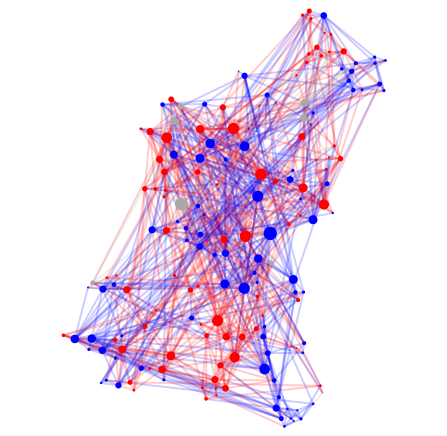

#4 C. Elegans, Age 16 hours


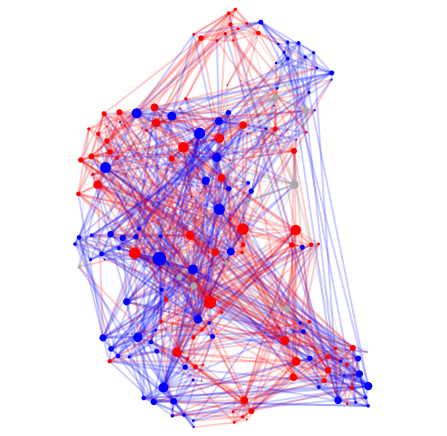

#5 C. Elegans, Age 23 hours


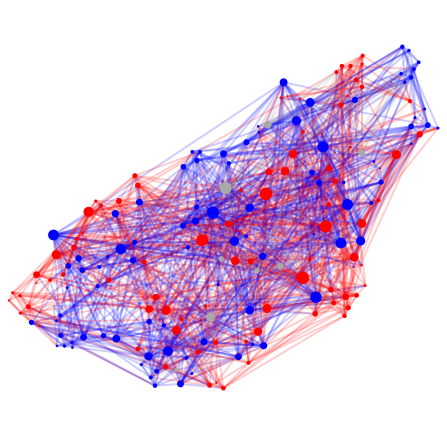

#6 C. Elegans, Age 27 hours


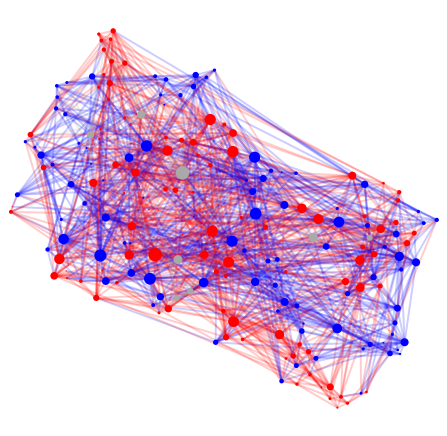

#7 C. Elegans, Age 45 hours


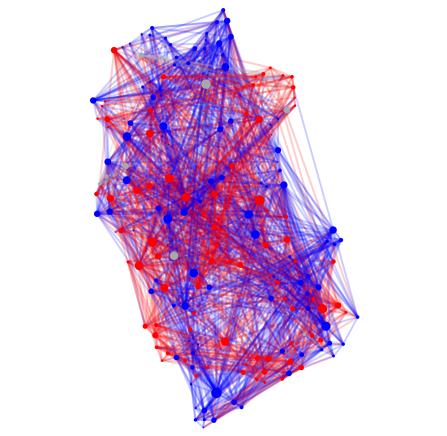

#8 C. Elegans, Age 45 hours


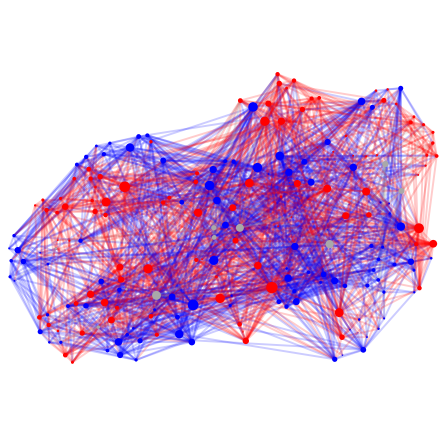

In [10]:
for i in range(len(layouts)):
    print('#' + str(i+1) + ' C. Elegans, Age ' + str(ages[i]) + ' hours')
    gr.layouts.show_graph(undirected_cleaned[i].to_undirected(), layouts[i], color_maps[i],
                          vertex_shape='.', vertex_alpha=1.,
                          edge_alpha=.2, edge_line_width=2.,
                          dpi=70, figure_height=8, figure_width=8)

Once again, lets get some basic stats for each connectome.

In [11]:
data = {'Number of Nodes': [],
        'Number of Edges': [],
        'Density': [],
        'Max Out Degree': [],
        'Max In Degree': []}
index = []
for i, connectome in enumerate(connectomes):
    num_nodes = len(connectome.nodes)
    data['Number of Nodes'].append(num_nodes)
    num_edges = len(connectome.edges)
    data['Number of Edges'].append(num_edges)
    data['Density'].append(num_edges / (num_nodes * (num_nodes - 1)))
    data['Max Out Degree'].append(max(connectome.out_degree, key=lambda x: x[1])[1])
    data['Max In Degree'].append(max(connectome.in_degree, key=lambda x: x[1])[1])
    index.append('#' + str(i+1) + ': C. Elegans: age ' + str(ages[i]) + ' hours')
df = pd.DataFrame.from_dict(data)
df.index = index
df.head(8)

,Number of Nodes,Number of Edges,Density,Max Out Degree,Max In Degree
#1: C. Elegans: age 0 hours,187,849,0.024409,16,19
#2: C. Elegans: age 5 hours,194,1095,0.029245,25,21
#3: C. Elegans: age 8 hours,198,1101,0.028226,23,23
#4: C. Elegans: age 16 hours,204,1324,0.031971,22,26
#5: C. Elegans: age 23 hours,211,1763,0.039788,28,27
#6: C. Elegans: age 27 hours,216,1707,0.036757,33,30
#7: C. Elegans: age 45 hours,222,2450,0.049937,36,40
#8: C. Elegans: age 45 hours,219,2416,0.050605,32,40


## C. Elegens: Worm Wiring Connectome, Hermaphrodite and Male ##

This dataset contains full, detailed, connectomes for both C. Elegans sexes. Data for chemical and electrical synapses is contained in this repository,
but here we look more deeply at the chemical connectome.

{cite}`cook_whole-animal_2019`

Again, visualization and analysis is done as before.

In [12]:
# load chemical synapse connectome files
path_h = '../json_connectomes/worm_wiring/connectome/Hermaphrodite/0.json'
path_m = '../json_connectomes/worm_wiring/connectome/Male/0.json'
connectomes = []
connectomes.append(GraphIO.load(path_h)[0])
connectomes.append(GraphIO.load(path_m)[0])


In [13]:
layouts = [None]*len(connectomes)
undirected_cleaned = [None]*len(connectomes)
for i, connectome in enumerate(connectomes):
    temp_g = nx.convert_node_labels_to_integers(connectome.to_undirected())
    undirected_cleaned[i], layouts[i] = gr.layouts.layout_tsne(temp_g,
                                                               perplexity=20,
                                                               n_iter=10000000)

In [14]:
color_maps = [{} for i in range(len(connectome))]
hemi_map = {'left': '#FF0000',
            'right': '#0000FF',
            None: '#A9A9A9'}
for i, connectome in enumerate(undirected_cleaned):
    for node in connectome.nodes(data=True):
        try:
            side = node[1]['hemisphere'].strip()
        except (AttributeError, KeyError):
            side = None
        color_maps[i][node[0]] = hemi_map[side]

Hermaphrodite Connectome


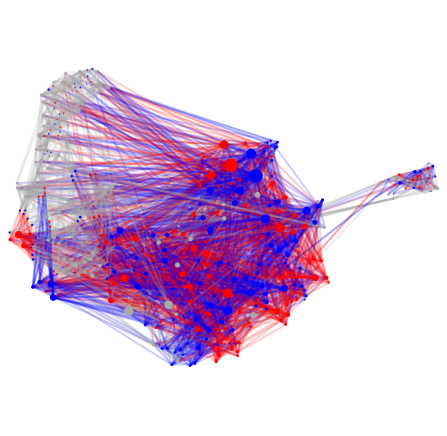

Male Connectome


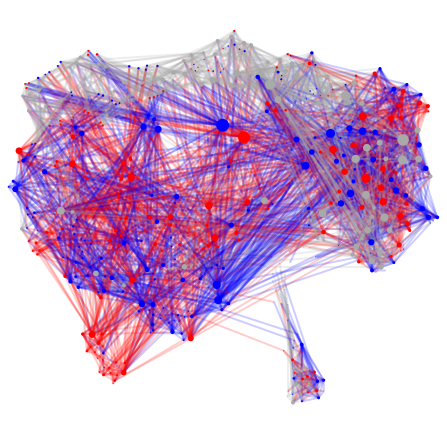

In [15]:
labels = ['Hermaphrodite Connectome', 'Male Connectome']
for i in range(len(layouts)):
    print(labels[i])
    gr.layouts.show_graph(undirected_cleaned[i].to_undirected(),
                          layouts[i], color_maps[i],
                          vertex_shape='.', vertex_alpha=1.,
                          edge_alpha=.2, edge_line_width=2.,
                          dpi=70, figure_height=8, figure_width=8)


Now let's get the basic graph statistics.

In [16]:
data = {'Number of Nodes': [],
        'Number of Edges': [],
        'Density': [],
        'Max Out Degree': [],
        'Max In Degree': []}
for i, connectome in enumerate(connectomes):
    num_nodes = len(connectome.nodes)
    data['Number of Nodes'].append(num_nodes)
    num_edges = len(connectome.edges)
    data['Number of Edges'].append(num_edges)
    data['Density'].append(num_edges / (num_nodes * (num_nodes - 1)))
    data['Max Out Degree'].append(max(connectome.out_degree, key=lambda x: x[1])[1])
    data['Max In Degree'].append(max(connectome.in_degree, key=lambda x: x[1])[1])

df = pd.DataFrame.from_dict(data)
df.index = ['C. Elegans: Worm Wiring, Hermaphrodite, Chemical',
            'C. Elegans: Worm Wiring, Male, Chemical']
df.head(2)

,Number of Nodes,Number of Edges,Density,Max Out Degree,Max In Degree
"C. Elegans: Worm Wiring, Hermaphrodite, Chemical",454,4879,0.023723,49,65
"C. Elegans: Worm Wiring, Male, Chemical",575,5306,0.016076,50,49


## Drosophila (FAFB Dataset): Mushroom Body ##

Using new High Throughput Electron Micrography data, this dataset contains a subset of the whole Fly Brain Connectome, namely the mushroom body. This dataset is much smaller than the others, because it focuses
on a specific neural circuit.

{cite}`zheng_complete_2018`


In [17]:
path = '../json_connectomes/fafb.json'
connectome, _, _, _ = GraphIO.load(path)

In [18]:
undirected_cleaned, layout = gr.layouts.layout_tsne(connectome.to_undirected(),
                                                    perplexity=20, n_iter=1000)

In [19]:
color_map = {}
side_map = {'L': '#FF0000',
            'R': '#0000FF',
            None: '#A9A9A9'}

for node in connectome.nodes(data=True):
    try:
        side = node[1]['Side'].strip()
    except (KeyError, AttributeError):
        side = None
    color_map[node[0]] = side_map[side]

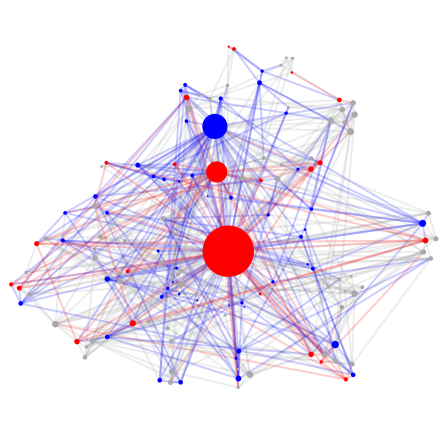

In [20]:
gr.layouts.show_graph(undirected_cleaned, layout, color_map,
                      vertex_shape='.', vertex_alpha=1.,
                      edge_alpha=.2, edge_line_width=2.,
                      dpi=70, figure_height=8, figure_width=8)

FAFB Basic Statistics:

In [21]:
num_nodes = len(connectome.nodes)
num_edges = len(connectome.edges)
density = num_edges / (num_nodes * (num_nodes - 1))
data = {'Number of Nodes': [num_nodes],
        'Number of Edges': [num_edges],
        'Density': [density],
        'Max Out Degree': max(connectome.out_degree, key=lambda x: x[1])[1],
        'Max In Degree': max(connectome.in_degree, key=lambda x: x[1])[1]}
df = pd.DataFrame.from_dict(data)
df.index = ['FAFB Connectome']
df.head()

,Number of Nodes,Number of Edges,Density,Max Out Degree,Max In Degree
FAFB Connectome,145,831,0.039799,106,101


## Drosophila Hemibrain Connectome ##

Largest synaptic level connectome ever recorded, includes large portion of a fly's CNS. Imaged using a combination of EM and
light microscopy.

{cite}`xu_connectome_2020`

This connectome is much larger than the others, so some steps will take longer to run.

In [22]:
path = '../json_connectomes/neuPrint_graphs.json'
connectome, _, _, _ = GraphIO.load(path)

We can't visualize this connectome using grapological layouts becuase it is too large! We can still get the basic stats though:


In [23]:
num_nodes = len(connectome.nodes)
num_edges = len(connectome.edges)
density = num_edges / (num_nodes * (num_nodes - 1))
data = {'Number of Nodes': [num_nodes],
        'Number of Edges': [num_edges],
        'Density': [density],
        'Max Out Degree': max(connectome.out_degree, key=lambda x: x[1])[1],
        'Max In Degree': max(connectome.in_degree, key=lambda x: x[1])[1]}
df = pd.DataFrame.from_dict(data)
df.index = ['Drosophila Hemibrain Connectome']
df.head()



,Number of Nodes,Number of Edges,Density,Max Out Degree,Max In Degree
Drosophila Hemibrain Connectome,186061,7084254,0.000205,6070,4388
